## Multivariate Time Series Analysis on Crude Oil

#### The code below has been generated with the help of *GPT-3.5-Turbo Chat Interface*, *GitHub Copilot*, and with the help of a *research article*, together with articles on *Medium* and *TowardsDataScience* (references included at the end of the notebook).

##### NOTE: For the sake of conciseness, I refrain from explaining, in detail, the processes followed in developing this model. Feel free to inquire regarding these.



In [164]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load market data from CSV file
data = pd.read_csv('oil_data.csv')

# Remove duplicate rows
data = data.drop_duplicates()

# Convert date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort the data by date
data = data.sort_values(by='Date')

# Fill missing values using forward fill
data = data.fillna(method='ffill')

# Define the features to be used for prediction
# Correlation Analysis, PCA, Information Gain, etc.
features = ['Open', 'High', 'Low', 'Price', 'Volume2']

# Normalize the features using min-max scaler
scaler = MinMaxScaler() # input scaler
scaler2 = MinMaxScaler() # output scaler
data[features] = scaler.fit_transform(data[features])
scaler2.fit(data[['Price']])

# Create lagged features for time series forecasting
lags = 5
for f in features:
    for lag in range(1, lags+1):
        col = f'{f}_lag_{lag}'
        data[col] = data[f].shift(lag)

# Drop rows with missing values introduced by lagging
data = data.dropna()

# Define target variable
target = 'Price'

# Create the target variable shifted by the desired forecast horizon
forecast_horizon = 1
data['target'] = data[target].shift(-forecast_horizon)

# Drop rows with missing values introduced by shifting
data = data.dropna()

# Split the data into training and test sets
train_size = int(len(data) * 0.8)
train = data[:train_size]
test = data[train_size:]

# Save the training and test sets to CSV files
train.to_csv('new_train.csv', index=False)
test.to_csv('new_test.csv', index=False)

Load Train Data

In [151]:
import numpy as np

# Load preprocessed training data from CSV file
train_data = pd.read_csv('new_train.csv')

# Split the training and test sets into features and targets
train_features = [f'{f}_lag_{forecast_horizon}' for f in features]
target_feature = 'target'

# Convert the Pandas DataFrames to NumPy arrays
X_train = train_data[train_features].values
y_train = train_data[target_feature].values

# Reshape the input features to match LSTM input requirements
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

Load Test Data

In [149]:
# Load preprocessed test data from CSV file
test_data = pd.read_csv('new_test.csv')

# Split the training and test sets into features and targets
test_features = [f'{f}_lag_{forecast_horizon}' for f in features]

# Convert the Pandas DataFrames to NumPy arrays
X_test = test_data[test_features].values
y_test = test_data[target_feature].values

# Reshape the input features to match LSTM input requirements
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Model

In [139]:
# Define the LSTM model architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model_simple = Sequential()

#layer 1 of LSTM
model_simple.add(LSTM(units=64,return_sequences=True,input_shape=(X_train.shape[1],len(features))))
model_simple.add(Dropout(0.2))

#layer 2 of LSTM
model_simple.add(LSTM(units=32,return_sequences=True,input_shape=(X_train.shape[1],len(features))))
model_simple.add(Dropout(0.2))

#layer 3 of LSTM
model_simple.add(LSTM(units=32,return_sequences=True,input_shape=(X_train.shape[1],len(features))))
model_simple.add(Dropout(0.2))

#layer 4 of LSTM
model_simple.add(LSTM(units=16,input_shape=(X_train.shape[1],len(features))))
model_simple.add(Dropout(0.2))

##Hidden Layer 
model_simple.add(Dense(units=16))
#Output layer of model
model_simple.add(Dense(units=1))

In [140]:
# Print the model summary
model_simple.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 1, 64)             17920     
                                                                 
 dropout_20 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_27 (LSTM)              (None, 1, 32)             12416     
                                                                 
 dropout_21 (Dropout)        (None, 1, 32)             0         
                                                                 
 lstm_28 (LSTM)              (None, 1, 32)             8320      
                                                                 
 dropout_22 (Dropout)        (None, 1, 32)             0         
                                                                 
 lstm_29 (LSTM)              (None, 16)              

Compile and Train

In [141]:
# Compile the model
model_simple.compile(optimizer='adam', loss='mse')

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model_simple.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=2)

Epoch 1/100
67/67 - 12s - loss: 0.1438 - val_loss: 0.0277 - 12s/epoch - 186ms/step
Epoch 2/100
67/67 - 1s - loss: 0.0118 - val_loss: 0.0078 - 608ms/epoch - 9ms/step
Epoch 3/100
67/67 - 0s - loss: 0.0070 - val_loss: 7.5129e-04 - 473ms/epoch - 7ms/step
Epoch 4/100
67/67 - 0s - loss: 0.0053 - val_loss: 9.9311e-04 - 470ms/epoch - 7ms/step
Epoch 5/100
67/67 - 0s - loss: 0.0046 - val_loss: 0.0017 - 401ms/epoch - 6ms/step
Epoch 6/100
67/67 - 0s - loss: 0.0041 - val_loss: 0.0025 - 459ms/epoch - 7ms/step
Epoch 7/100
67/67 - 0s - loss: 0.0040 - val_loss: 0.0021 - 472ms/epoch - 7ms/step
Epoch 8/100
67/67 - 0s - loss: 0.0034 - val_loss: 8.7653e-04 - 421ms/epoch - 6ms/step


Plot Training and Validation Results

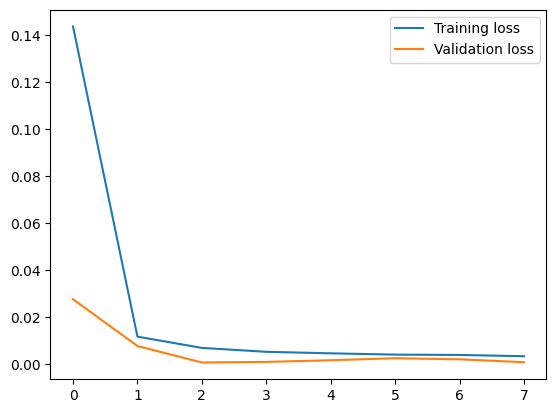

In [142]:
# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [143]:
# Save the model
model_simple.save('model_simple.h5')

Load the model and Evaluate

In [166]:
# Load the model
from tensorflow.keras.models import load_model

model_simple = load_model('model_simple.h5')

In [167]:
# Use the model to make predictions
y_pred = model_simple.predict(X_test)
print(y_pred.shape)

17/17 [==============================] - 2s 2ms/step
(530, 1)


In [168]:
# Invert the predictions to the original scale
y_pred_inv = scaler2.inverse_transform(y_pred)
y_test_inv = scaler2.inverse_transform(y_test.reshape(-1, 1))
y_train_inv = scaler2.inverse_transform(y_train.reshape(-1, 1))

Plot Evaluation Results

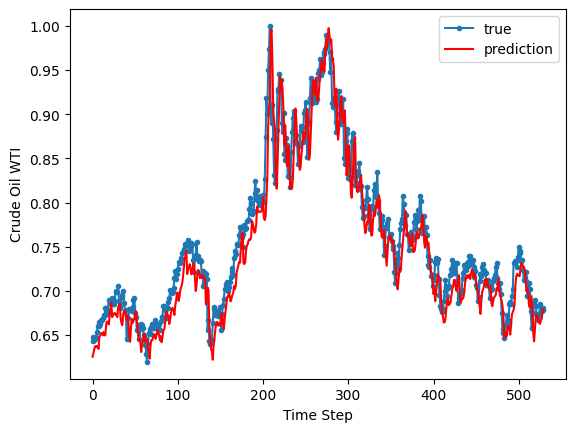

In [169]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Crude Oil WTI')
plt.xlabel('Time Step')
plt.legend()
plt.show()

Compare with Historical Data

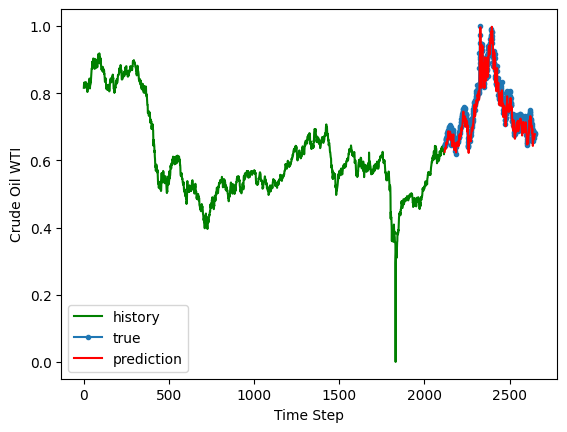

In [170]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Crude Oil WTI')
plt.xlabel('Time Step')
plt.legend()
plt.show()

Metrics

In [173]:
# Calculate the RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'Root Mean Square Error: {rmse:.3f}')
print(f'Mean Absolute Error: {mae:.3f}')
print(f'R2 Score: {r2:.3f}')


Root Mean Square Error: 0.027
Mean Absolute Error: 0.022
R2 Score: 0.897


### References:

1) https://www.investing.com/commodities/crude-oil
2) https://www.kaggle.com/code/ryanholbrook/time-series-as-features
3) https://medium.com/@vinayarun/from-scratch-an-lstm-model-to-predict-commodity-prices-179e12445c5a
4) https://github.com/OrestisMk/OrestisMk-Multivariate-forecast-with-VAR-SVR-RNN-LSTM/blob/main/RNN-LSTM(2%20models).ipynb
5) Vancsura L, Tatay T, Bareith T. Evaluating the Effectiveness of Modern Forecasting Models in Predicting Commodity Futures Prices in Volatile Economic Times. Risks. 2023; 11(2):27. https://doi.org/10.3390/risks11020027